# Hybrid Virtual Sensors

In this tutorial we design a hybrid approach using the linear transfer function in frequency domain in combination with autoregressive Neural Networks. This is the fifth tutorial on the SoftSensor Toolbox building upon the other four. Please check out the previous tutorial for more detailed informations concerning the specific models as well as the hyperparameter optimization. Furthermore we utilise advanced techniques for stabelization in the predicition. 

Hybrid models are extremely useful for systems that have a *strong linear component with slight non-linear deviations*. For these cases, hybrid models can offer a strong benefit in terms of accuracy and computational effort compared to pure deep learning or classical models.

## Data Loading
The data loading process works similarly to the previous tutorials. A steering system under road conditions is used as the data basis. The linear antecedent of the system is significant, which is why the use of hybrid approaches is appropriate.

These are matlab files which require the use of a special function to read the data. The internal function `read_vehicle_data` provides the functionality to read the matfile for the individual sensors.

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data_path = os.path.join(os.path.abspath(""), 'data')

input_sensors = [f'input_{i}' for i in range(1, 10)]
output_sensors = [f'output_{i}' for i in range(1, 4)]

file_names = [f for f in os.listdir(data_path) if
                    os.path.isfile(os.path.join(data_path, f))]
df_list = [pd.read_parquet(os.path.join(data_path, n)) for n in file_names]

## Data Preprocessing

To enable hybrid models, preprocessing is carried out in two steps. In the first step, the data is read into a `Meas_handling` class, filtered and scaled as explained in the previous tutorials.

In [3]:
from softsensor.meas_handling import Meas_handling
fs = 1/np.mean(df_list[0].index.diff().dropna())
data_handle = Meas_handling(df_list[:2], file_names[:2], input_sensors, output_sensors, fs, df_list[2:], file_names[2:])

freq_lim = [12, 1250]
data_handle.Resample(fs=4096)
data_handle.Filter(freq_lim)
data_handle.Scale()

In the second step, the linear solution of the system is calculated. If another solution is known, for example from simulations, this can of course also be used. To calculate the linear solution, the Frequency Response Function (FRF) with the class `tf` is used. A detailed introduction to the calculation of linear solutions is described in `tutorial/01_linear_models.ipynb`. 

Then the difference between the linear solution and the original measurement data must be calculated. The use of the difference is necessary because the subsequent training with stability parameters leads to a simpler training with improved properties. 

As a last step, the `Meas_handling` class must be adapted so that the linear solution is also used as input in addition to the actual input sensors.

In [4]:
from softsensor.linear_methods import tf
from softsensor.eval_tools import comp_batch
import numpy as np

# compute linear solution
tf_class = tf(window_size=1024, hop=512, fs=data_handle.fs)
tf_class.fit(data_handle.train_df, input_sensors, output_sensors)
_ = comp_batch([tf_class], data_handle, data_handle.train_names + data_handle.test_names, ['lin'])

# compute difference between linear solution and measured output
lin_labels = [f'{s}_lin' for s in output_sensors]
for df in data_handle.train_df + data_handle.test_df:
    for s, l in zip(output_sensors, lin_labels):
        df[f'{s}_diff'] = np.array(df[s]) - np.array(df[l])

# redefine input sensors for subsequent models
data_handle.input_sensors = input_sensors + lin_labels
data_handle.output_sensors = [f'{s}_diff' for s in output_sensors]

In [5]:
data_handle.train_df[0]

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,output_1,output_2,output_3,output_1_lin,output_2_lin,output_3_lin,output_1_diff,output_2_diff,output_3_diff
0.000000,-0.000055,2.362300e-04,0.000162,0.000200,0.000197,-0.000057,0.000119,0.000038,0.000065,-0.000035,0.000205,0.000270,-0.061786,0.040316,0.033076,0.061751,-0.040111,-0.032806
0.000244,0.000846,1.571275e-04,0.001680,0.000504,0.000207,-0.000031,-0.044669,0.000102,-0.079320,0.026044,-0.021564,0.041598,-0.029128,0.027044,0.009610,0.055172,-0.048608,0.031988
0.000488,-0.000661,7.843154e-05,-0.002396,-0.000110,0.000374,0.000197,-0.046712,0.000137,-0.096743,0.029387,-0.026593,0.017143,0.032557,-0.020947,-0.019499,-0.003170,-0.005646,0.036643
0.000732,-0.001176,4.163388e-07,-0.001527,0.000837,0.000088,0.000009,-0.032656,0.000191,-0.080102,0.024924,-0.022350,-0.018312,0.070948,-0.031617,-0.043709,-0.046025,0.009267,0.025397
0.000977,0.001343,-7.922324e-05,0.002755,0.001199,0.000177,0.000058,-0.025086,0.000270,-0.082876,0.024607,-0.022111,0.011009,0.046411,0.014800,-0.034840,-0.021804,-0.036911,0.045850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.656982,0.054889,1.438318e-01,0.126539,0.012586,0.063341,-0.003280,-0.084506,0.008417,-0.087022,0.119114,-0.026520,-0.005468,0.048806,0.021063,-0.026784,0.070308,-0.047583,0.021317
4.657227,0.064895,7.503008e-02,0.045369,-0.012234,0.047204,-0.001684,-0.047624,0.062081,-0.079236,0.136890,-0.065045,0.013452,0.029303,-0.014047,-0.021032,0.107587,-0.050998,0.034484
4.657471,0.054527,-6.909275e-02,0.132877,-0.075560,-0.013636,0.001647,-0.007482,0.076393,-0.040331,0.071363,-0.060544,-0.133363,0.004782,-0.024253,-0.032297,0.066581,-0.036291,-0.101066
4.657715,0.020842,-1.246632e-01,0.194103,-0.078980,-0.048692,-0.000708,0.009590,0.039913,-0.000082,-0.007840,-0.022662,-0.181809,0.013488,0.003680,-0.023197,-0.021328,-0.026342,-0.158612


## Define Model
We define an Autoregressive Neural Network (ARNN) to approximate the functional dependency between input and output as a simple Neural Network. The model is autoregressive as it feeds back in the past outputs into the equation, leading to:

$y_i(t+1) = f(\mathbf{x}_i(t, ..., t-w_x), \mathbf{y}_i(t, ..., t-w_y))$

Formally this model is called NARX (nonlinear autoregressive model with exogenious input) and takes:

 * number of input channels (`input_channels`)
 * number of output channels (`pred_size`)
 * window size (`window_size`)
 * recurretn window size (`rnn_window`)
 * neurons in the hidden layers (`hidden_size`)
 
as input. We need to define an extendet input space as `len(input_sensors + output_sensors)` to include the additional input from the linear solution.

In [6]:
from softsensor.autoreg_models import ARNN

ARNN = ARNN(input_channels=len(input_sensors + output_sensors), pred_size=len(output_sensors), window_size=50, rnn_window=50,
            hidden_size=[128, 64, 32, 16], activation='leaky_relu')

## Model training

After we have defined the model, the next step is to adapt the model to the data. The training and validation data can be extracted from the predefined `data_handle` class and then trained using the `train_model` function. The setup for the training works similar to normal non-hybrid methods

In [7]:
import torch.nn as nn
import torch.optim as optim

max_epochs = 30 # Max Epochs to train the Model
lr = 1e-4 # np.logspace(np.log10(1e-5), np.log10(1e-1), max_epochs, endpoint=True)
rel_perm = 5e-4 # gaussian noise added to signals
criterion = nn.MSELoss()
optimizer = optim.Adam(ARNN.parameters(), lr=lr)

train_loader, val_loader = data_handle.give_torch_loader(window_size=50 , keyword='training', batch_size=256,
                                                         rnn_window=50)

The training process is done as in `tutorials/02_ARNN.ipynb`. However, we introduce a change and use a scheduler for the stability parameter. Since we know that a negative stability score (SC) means stable behaviour, we use a high parameter if SC is greater than zero and a low parameter if SC is less than zero. 
We therefore check the SC inbetween the training process and adjust the stabelizer during training. The scheduling results in a SC close to zero after the training process, thus favouring stable behaviour without interfering too much with the main criterion.

We therefore use a log-function for a SC < 0 and a linear function for SC > 0 

In [8]:
from softsensor.stab_scheduler import log_lin_stab
stab = log_lin_stab(ARNN, s0=1e-7, s1=1e-2, m=.001)

We visualize the Stability Parameter to show the specific advantages over simpler methods without scheduling

Text(0.5, 0, 'SC')

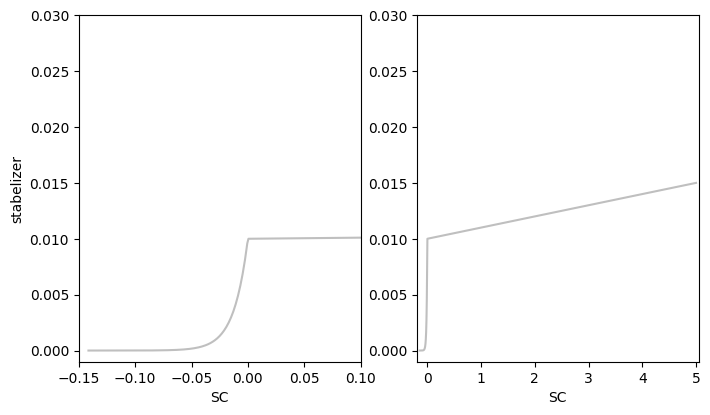

In [9]:
import matplotlib.pyplot as plt
stab.track = False
sc_original = np.linspace(-1/np.sqrt(50), 5, 5000)
eta_original = [stab.get_stab(ARNN, sc=sco) for sco in sc_original]

fig, ax = plt.subplots(1,2, figsize=(8,4.5))
ax[0].plot(sc_original, eta_original, color='grey', alpha=.5)
ax[0].set_xlim(-.15, .1)
ax[0].set_ylim(-.001, .03)
ax[1].plot(sc_original, eta_original, color='grey', alpha=.5)
ax[1].set_ylim(-.001, .03)
ax[0].set_ylabel('stabelizer')
ax[0].set_xlabel('SC')
ax[1].set_xlabel('SC')

Afterwards we train our model similar to the previous tutorials

In [10]:
from softsensor.train_model import train_model
results = train_model(ARNN, train_loader, max_epochs, optimizer,
                        device='cpu', criterion=nn.MSELoss(), val_loader=val_loader,
                        patience=5, print_results=True, stabelizer=stab,
                        give_results=True, rel_perm=rel_perm)

Training Process finished by early stopping


## Model Evaluation
To Evaluate our model on testing data we use the predefined functions `comp_pred`, which computes the prediction for a defined track in the data_handle class. As track we choose our testing track, which can be accessed using the internal variable `test_names`. Furthermore we compute

In [11]:
from softsensor.eval_tools import comp_batch
train_pred = comp_batch([ARNN], data_handle, data_handle.train_names, ['ARNN'])
test_pred = comp_batch([ARNN], data_handle, data_handle.test_names, ['ARNN'])

Since we have only used one model for the hybrid modelling to calculate the difference between the linear and the measured solution, the linear solution must still be added in post-processing for the model and the output

In [12]:
for i, df in enumerate(train_pred):
    for out_s in output_sensors:
        train_pred[i][f'{out_s}_ARNN'] = df[f'{out_s}_diff_ARNN'] + df[f'{out_s}_lin']

for i, df in enumerate(test_pred):
    for out_s in output_sensors:
        test_pred[i][f'{out_s}_ARNN'] = df[f'{out_s}_diff_ARNN'] + df[f'{out_s}_lin']

Afterwards we visualize the results

<Axes: >

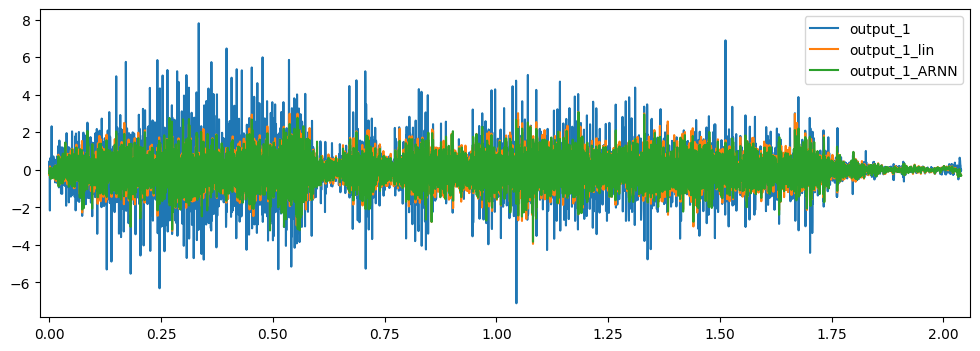

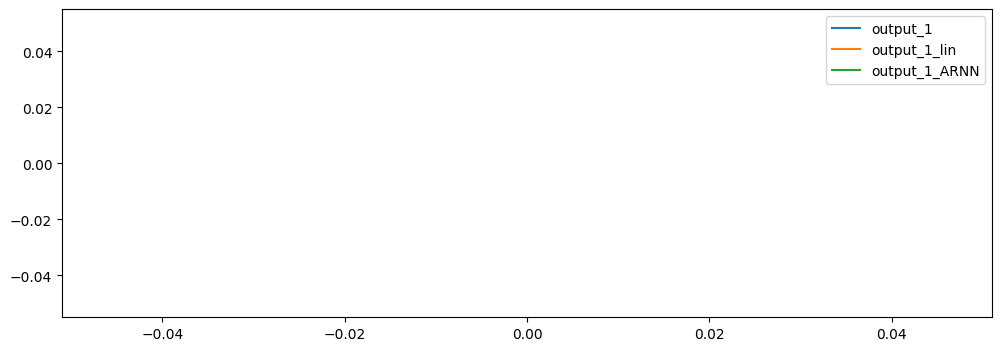

In [13]:
cols = ["output_1", "output_1_lin", "output_1_ARNN"]
test_pred[0][cols].plot(figsize=(12,4))
test_pred[0][cols][3:3.02].plot(figsize=(12,4))

Lastly we compute a comparison for as a Mean-Squared-Error in Frequency domain (MSLE) as well as Mean Square Error(MSE)  in time domain.

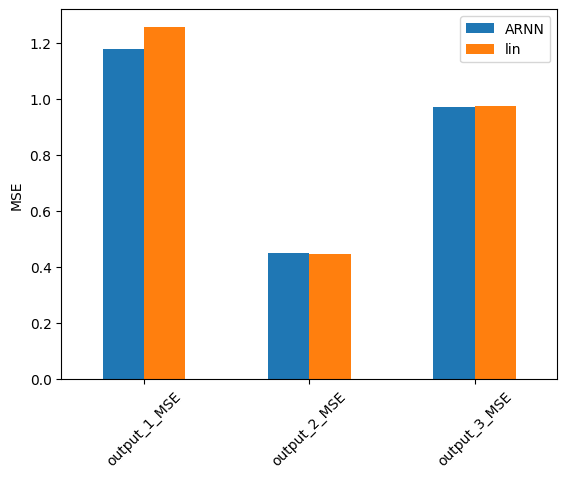

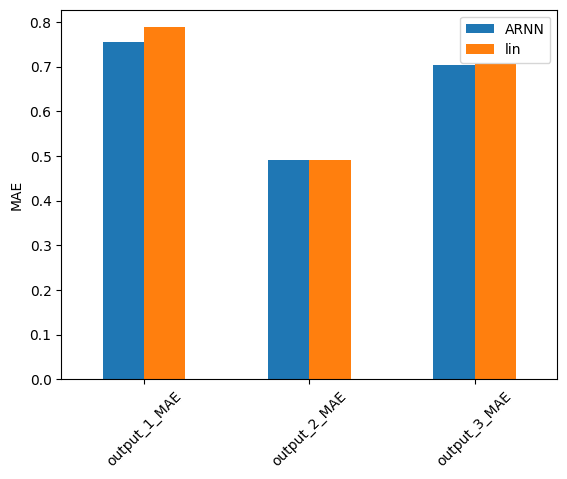

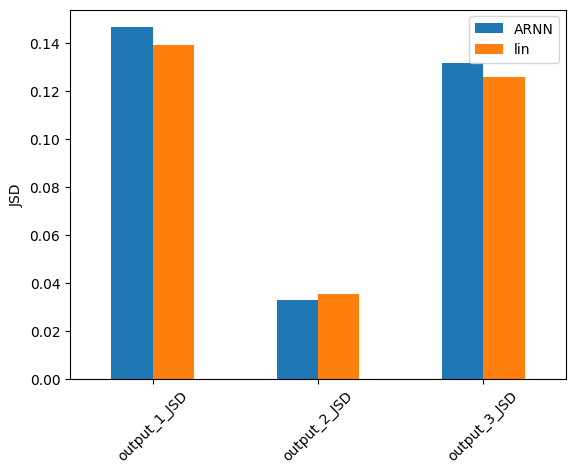

In [14]:
from softsensor.eval_tools import comp_error

error = comp_error(test_pred[0], output_sensors, fs, names=['ARNN', 'lin'], metrics=['MSE', 'MAE', 'JSD'], freq_range=freq_lim)
for n in ['MSE', 'MAE', 'JSD']:
    error.filter(regex=n, axis=0).plot.bar(ylabel=f'{n}', rot=45)